# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
Our dataset was downloaded from https://housestockwatcher.com/api, a public project created by whistleblowers that reports all stock transactions made by US House representatives and it contains information about these transactions from 2020-01-02 to 2021-11-02. After the work we did on this dataset during a statistical analysis, we were left with the assumption that there was not a major difference between Democrats and Republicans as far as financial habits were concerned. However we would like to further test this theory. Is it really true that there is no difference at all between how each party trades? This is the prediction problem we are trying to solve; predict a trade's political affiliation by looking at features such as 'owner' (who owns the account that makes the trade), 'state', (which state the trader represents), 'ticker', the ticker that they're trading, and several more features. The variable we'll be predicting is 'party', the political affiliation of the person making the trade, and our estimator will be accuracy since there is no large imbalance of the trades made by either party. Although Libertarians are not well represented, and accuracy would not reflect them very effectively, we aren't too interested in correctly classifying the single Libertarian in the House of Representatives. That being said, although accuracy will be our primary evaluation metric, we will consider the F1 score, and the sensitivity of our model as well.

### Cleaning and EDA
Our cleaning of the original dataset took place in the following steps:
1. Replace all the fake missing values with real missing values with pd.replace
2. Hand fill inaccurate dates by visiting the disclosure PDFs linked in the dataset and found on the House website, using pd.at
3. Convert dates to real pd.Timestamps using pd.to_datetime
4. Hand fill 4 trivial missing asset descriptions with pd.at
5. Merge in a dataframe with the political affiliation and consistent name of each representative (generated through webscraping Congress website which allows webscraping:  https://www.congress.gov/robots.txt)
6. Create numerical column from 'amount' by taking the minimum of every categorical range
7. String clean 'asset_description' column

There are two weaknesses of the data-generating process that will carry over to our modeling and analysis. These are the fact that we weren't able to canonicalize the asset_descriptions into consistent values, and that the numerical column only contains minimums which may not be a good representation of the actual trade dollar values. The former is because of the sheer diversity of assets purchased by the US House representatives, and the latter is because the 'amount' is a human filled categorical column with inconsistent representations of the trade value (such as '1001-', '1001-50000', and '1001-15000'), all of which have a minimum value of '1001' but no consistent maximum value, thus making it impossible to ascertain the actual differences in values of these types of trades.

### Baseline Model
For our baseline model we chose the following features: 
1. owner - OneHotEncoder()
2. type - OneHotEncoder()
3. min_value - OrdinalEncoder()
4. ticker - OneHotEncoder()
5. cap_gains_over_200_usd - Identity

Our dataset does not have any quantitative features, other than the pseudo-quantitative column of min_value. Thus we only have nominal (owner, type, ticker) and ordinal (min_value) features in our model. Ultimately this leads to a relatively mediocre accuracy score of around 0.71 for our test set and 0.73 for our training set. To us this is below what we would want to see since the idea is to perhaps transform this model into a way to gauge insider trading. A higher score would allow us to do that with relative certainty. Why do we say that min_value is pseudo-quantitative? Because it is not an accurate reflection of trading values as explained above.

### Final Model
The features we added were the binned time delta between disclosure_date and transaction_date as well as whether or not the ticker was listed on the NYSE. The former was added because  some representatives could be less diligent than others in reporting transactions, and this engineered feature could give us insight into those reporting habits. In addition, after a quick analysis based on quantile-cutting our timedeltas, we realized that Republicans were severely underrepresented in the higher bins. Since our model struggled with recall for Republicans, we thought that this could help. The latter was chosen because there is a large amount of rhetoric in congress around foreign and off the books spending. Some of that could be reflected in the financial habits of either party. Ultimately there was only a small difference in the percentage makeup of parties who bough listed vs unlisted assets, but increasing our recall score for Republicans was really crucial. We also added state since states are financial data: They indicate the cost of living, taxes, and financial representatives, all of which vary on a state by state basis. Furthermore states demonstrate a strong indicator of historical political affiliation: Some states vote Republican or Democrat very consistently. The model type we chose was a tree-based classifier (RandomForestClassifier). This was due to a robust and exhaustive GridSearchCV that tested three different models and various parameters for each. The ideal parameters were max_depth = None, min_samples_leaf = 2, min_samples_split = 3. Interesting here is the fact that our max_depth is 'None' which means that our DecisionTree is not limited by a set number of decisions: It can recurse until it makes a decision. Our score ended up being a rather high 0.975. 

### Fairness Evaluation
The fairness problem we decided to evaluate was higher-value trades vs lower-value trades. This is because Republicans trade, in total, higher-value assets than Democrats. Since our recall with Republicans has historically been comparatively low, we wanted to see if our model was better at predicting lower value trades than higher value trades and our lower recall was merely a symptom of the true problem. We chose as our test statistic the recall, which is in following with our question, and then ran a permutation test with a significance level of 0.05. Our null hypothesis was that our model treats both groups equally, and our alternative hypothesis was that high-value trades are treated unfairly. After the test we received a p-value of approximately __ and could not reject the null hypothesis. Thus there is likely not any parity difference here.

# Code

In [404]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import SparsePCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

Since this project is based on a dataset that we have already cleaned, we will demonstrate the messiness of the uncleaned dataset and explain the steps we took to clean it in this section. The initial csv we started with was downloaded from  https://housestockwatcher.com/api, a public project created by whistleblowers that reports all stock transactions made by US House representatives. Our dataset contains information about these transactions from 2020-01-02 to 2021-11-02. 

In [270]:
og_fp = os.path.join('data/', 'all_transactions.csv')
new_fp = os.path.join('data/', 'clean_transactions.csv')
unclean_transactions = pd.read_csv(og_fp)
transactions = pd.read_csv(new_fp, index_col=0)
all_feats = transactions

Since reading from a csv doesn't save datetimes, we'll re-convert the date columns from strings into datetimes.

In [271]:
transactions['disclosure_date'] = pd.to_datetime(transactions['disclosure_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

Below one can see a sample of the messy initial dataset. Particularly messy standouts include some misreported disclosure dates, an inconsistent categorical column in 'amount', inconsistent names in the 'representative' column, and fake nans in the form of '-''s.

In [272]:
unclean_transactions.head(1)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False


Our cleaning addresses most of these problems and also adds to our dataset a feature that contains the party affiliation of each representative. The only thing that we were not able to clean particularly effectively was the 'asset_description' feature, since the variability in naming is much more prevalent than that of the 'representative' feature. One can see a sample of this new cleaned dataset below:

In [273]:
transactions.head(1)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,name,party,min_value
0,2021,2021-10-04,2021-09-27,joint,BP,bp plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,"Foxx, Virginia",Republican,1001


To ensure the efficacy of our name cleaning, we chose to leave in the original messy 'representative' column in addition to our new cleaned 'name' column (both of these features contain the same information about the name of the representative). The only thing we're missing is the title of the representatives, but we deal with this below:

Interestingly we noticed that exactly 6 representatives have a title of 'None'. After doing some research we realized that this title is erroneous, and is better replaced by the actual title of 'Hon.' This is for two reasons: One, this is their actual title, and two, there aren't enough 'None', 'Mr.', 'Mrs.' titles to lead to an actual predictive model. Training on such a small sample would likely lead to memorization and not prediction. Since this is the case it may be better to omit the title column as a whole.

In [274]:
titles = transactions['representative'].str.split(' ').str[0]
w_title = transactions.assign(titles=titles)
w_title[w_title['titles'] == 'None']['name'].unique()

array(['Manning, Kathy E.', 'Hinson, Ashley', 'Ross, Deborah K.',
       'Jacobs, Sara', 'Newman, Marie', 'Spartz, Victoria'], dtype=object)

In [275]:
titles.value_counts(normalize=True)

Hon.    0.965344
Mr.     0.021700
None    0.010445
Mrs.    0.002510
Name: representative, dtype: float64

In [276]:
transactions = transactions.drop(columns='representative')

Since we'll be modeling on this dataset at some point it would be more prudent to fill nan values now. There are no solidly numerical columns in our data that have nans, so we can just fill the entire dataset's nans with '-'. This is proven below:

In [277]:
transactions.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     5844
ticker                    1023
asset_description            0
type                         0
amount                       0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
name                         0
party                        0
min_value                    0
dtype: int64

In [278]:
transactions = transactions.fillna('-')

In order to completely understand our missingness from a party de-aggregate perspective, below we show two histograms that demonstrate the distribution of ownership (one of the two features with missingness) for each party.

[Text(0.5, 1.0, 'Democratic Account Ownership Distribution')]

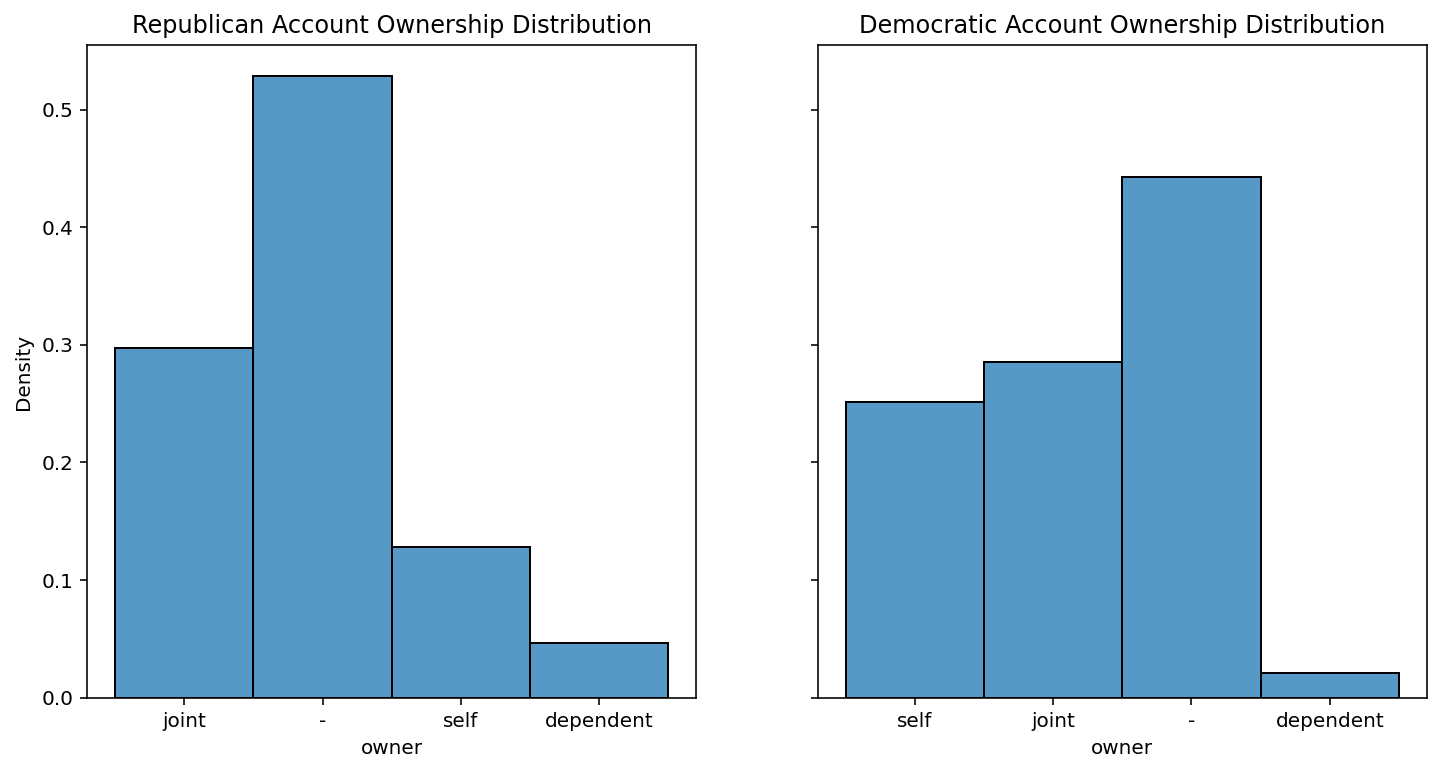

In [279]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(12,6))
sns.histplot(data=transactions[transactions['party'] == 'Republican'], x='owner', ax=ax1, stat='density')
sns.histplot(data=transactions[transactions['party'] == 'Democratic'], x='owner', ax=ax2, stat='density')
ax1.set(title='Republican Account Ownership Distribution')
ax2.set(title='Democratic Account Ownership Distribution')

In the below cell we analyze the missingness of ticker from a party perspective. Our analysis demonstrates that it is about equally missing for both parties (7.8% vs 9.2%) which means that it likely will not serve as a strong predictor of party affiliation.

In [280]:
transactions.groupby('party')['ticker'].value_counts(normalize=True).sort_values(ascending=False)[0:10]

party        ticker
Libertarian  DIS       1.000000
Republican   -         0.092325
Democratic   -         0.077555
Republican   NTAP      0.023251
Democratic   MSFT      0.019578
             TDDXX     0.014020
Republican   AAPL      0.013093
Democratic   RUN       0.011747
             AAPL      0.011368
Republican   AMZN      0.010835
Name: ticker, dtype: float64

In the below cell we calculate the percentage of the dataset that belongs to each party. This is done in order to demonstrate why accuracy can serve as a good evaluation metric. Although Libertarians are not well represented, and accuracy would not reflect them very effectively, we aren't too interested in correctly classifying the single Libertarian in the House of Representatives.

In [281]:
transactions.groupby('party').count()['amount']/transactions.shape[0]

party
Democratic     0.641053
Libertarian    0.000243
Republican     0.358704
Name: amount, dtype: float64

Something else to consider before we get into our modeling, is that Republicans seem to have, in total, traded for higher value than their Democrat counterparts. We come back to this often in our feature engineering.

<AxesSubplot:ylabel='party'>

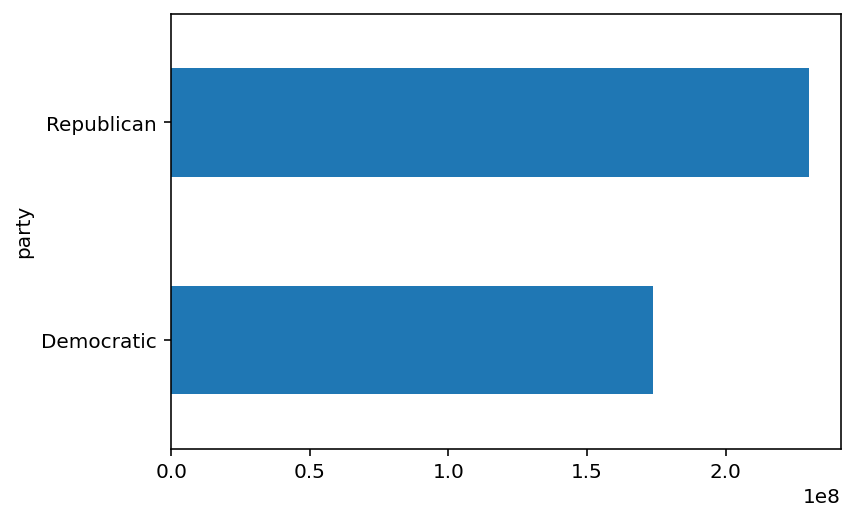

In [477]:
transactions.groupby('party').sum()['min_value'].plot(kind='barh')

Before we can get into feature engineering we have to drop some of the more granular features in our dataset. Since we're trying to predict a trader's political affiliation based solely on their trading data, it would be disingenuous to predict on unique or nigh-unique identifiers that exist in our dataset. These are features like 'ptr_link', unique for each set of trades, 'district', almost unique to every representative, and 'name', unique to each representative.

In [282]:
# drop ptr_link, district, name, party
state = transactions['district'].str.slice(0, 2)
transactions = transactions.assign(state=state)

In the below cell we filter out the single Libertarian from this analysis. The goal of this analysis is to classify between the two major parties, and given the lack of Libertarian representation, it would be too difficult and unfair to classify based on the small sample of Libertarian financial habits.

In [283]:
transactions = transactions[transactions['party'] != 'Libertarian']

Finally, to close out our cleaning of telltale features and properly obscure our data, we drop all of our major identifiers.

In [284]:
transactions = transactions.drop(columns=['ptr_link', 'district', 'name'])

### Baseline Model

In the below cell is a recap of what features we have left. This is the first step in selecting features for our baseline model:

In [285]:
transactions.columns

Index(['disclosure_year', 'disclosure_date', 'transaction_date', 'owner',
       'ticker', 'asset_description', 'type', 'amount',
       'cap_gains_over_200_usd', 'party', 'min_value', 'state'],
      dtype='object')

The first feature that caught out eye, was the value of ticker. We thought that since most House Representatives have some form of financial advisor, their ticker choices would be similar. We can see that this is almost the case in the below cell, as such we decided to OneHotEncode the ticker column, as well as the owner column since ownership type represents whether or not the representative is under financial advisement:

In [286]:
transactions['ticker'].sort_values().value_counts()

-        1023
MSFT      201
AAPL      148
TDDXX     111
NTAP      105
         ... 
RF$A        1
DNOW        1
MANLX       1
HCN         1
INST        1
Name: ticker, Length: 1934, dtype: int64

Next we examined our minimum value. This because our EDA revealed that Republicans made, in total, higher valued trades than Democrats. We thought it may serve as a decent predictor, so we added it in to our baseline using an OrdinalEncoder since there is a natural hierarchy to this categorical variable:

In [287]:
lst = transactions['min_value'].sort_values().unique()
lst

array([    1000,     1001,    15000,    15001,    50001,   100001,
         250001,   500001,  1000000,  1000001,  5000001, 50000000],
      dtype=int64)

In total, the features we chose were the following: 
1. owner - OneHotEncoder()
2. type - OneHotEncoder()
3. min_value - OrdinalEncoder()
4. ticker - OneHotEncoder()
5. cap_gains_over_200_usd - Identity

Type is a decent identifier since it is information about the representative. Each representative has a finite amount of accounts, and if a representative has more transaction types or more transactions of a certain type, this feature would capture that. Capital gains is another personal identifier, and a simple binary column that may shed more light on individual representatives.

In the below cell, we column transform all of our variables as mentioned above, and build our pipeline with a simple KNN classifier, which is often the most simple and first choice due to its robust applicability.

In [300]:
preproc = ColumnTransformer(
    transformers=[('onehots', OneHotEncoder(drop='first', handle_unknown='ignore'), ['owner', 'type', 'ticker']),
                  ('tv', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ['min_value']),
                  ('cap_gains', FunctionTransformer(), ['cap_gains_over_200_usd'])
                 ]
)
pl = Pipeline(steps=[('preproc', preproc), ('clf', KNeighborsClassifier())])

Next we split our data into training and test sets to ensure that we see an accurate measure of performance.

In [301]:
X_train, X_test, y_train, y_test = train_test_split(transactions.drop(columns='party'), transactions.party, test_size=0.2)

In the next cell, we fit and score our pipeline on our training data. 

In [302]:
pl.fit(X_train, y_train)
pl.score(X_train, y_train)

0.7262326617393946

As can be seen above our accuracy is __ This is rather low for our preferences, and we think we can do better given that we haven't even used all of our features yet. Of course this is only the training score; although the test score will not be higher, perhaps we can check our fit:

In [303]:
pl.score(X_test, y_test)

0.7076923076923077

Overall our training score was ~0.73 and our test score was ~0.71. We're not overfit at all, or at least don't seem to be, however this accuracy rate is still rather low. Let's see if our other metrics can give us a clearer picture of what went wrong with this model. In the below two cells we predict using our test set, and then run our classification report from sklearn.metrics to understand exactly what has happened:

In [304]:
preds = pl.predict(X_test)

In [305]:
pd.DataFrame(metrics.classification_report(y_test, preds, output_dict=True)).transpose()

,precision,recall,f1-score,support
Democratic,0.726872,0.853816,0.785247,1546.000000
Republican,0.654434,0.463203,0.542459,924.000000
accuracy,0.707692,0.707692,0.707692,0.707692
macro avg,0.690653,0.658510,0.663853,2470.000000
weighted avg,0.699774,0.707692,0.694423,2470.000000


As can be seen above, our recall for Democrats is very palatable. Recall is calculated as our true positives over all positives. This is a sign that we may be predicting more positive than negative. However in the grander scheme, this is really irrelevant: Our scores are pretty low across our precision for both Democrats and Republicans, and our recall for Republicans is really low. This demonstrates that we should consider adding in some more features that will help us determine when a representative is a Republican.

### Final Model

Despite the fact that our scores last time were lower than we hoped, we still think that most, if not all, of those features are still useful. Thus we elect to keep many of them, and since our data is not overfit this will not really harm our scores. In addition, there are some features we did not even use, like state. If we had the state involved that could give us a better understanding of who is Republican in our dataset. Southern states tend to be overwhelmingly Republican after all.

The first feature we decided to add in was the binned amount of time between transactions and the the date the transactions were disclosed. Perhaps some representatives were less diligent than others in reporting transactions, and this engineered feature could give us insight into those reporting habits.

In [420]:
ser = transactions['disclosure_date'] - transactions['transaction_date']
ser = pd.qcut(ser, q=10, labels=list(range(10)))
is_red = transactions['party'] == 'Republican'
transactions.assign(date_diff=ser).assign(is_red=is_red).groupby('date_diff')['is_red'].mean()

date_diff
0    0.496997
1    0.379923
2    0.381181
3    0.357639
4    0.435823
5    0.251453
6    0.257732
7    0.395588
8    0.401109
9    0.197080
Name: is_red, dtype: float64

As can be seen, after looking at the overall data, some of these bins are significantly Democrat leaning, while others are more Republican. Democrats do make up the majority of our dataset, however in some of these cases Republicans are really underrepresented, which we believe could help our classifier. In the below cell we create the FunctionTransformer used to engineer this feature in our pipeline:

In [306]:
def subtract_and_cut(x):
    ser = x.diff(axis=1).iloc[:, 1]
    return pd.DataFrame(pd.qcut(ser, q=10, labels=list(range(10))))
date_transform = FunctionTransformer(subtract_and_cut)

Unfortunately our analysis of ticker from last time didn't give us a solid grasp of labeling by party. However there is a large amount of rhetoric in congress around foreign and off the books spending. Maybe some of this is reflected in the financial habits of either party. In our original data, a ticker has a non-null value if it is currently listed on the NYSE. After some cleaning, we were able to get all tickers listed on the NYSE. Thus any null ticker is a company or stock not listed on the stock exchange, and is thus either foreign or not a share whatsoever. This allows us to engineer the following feature:

In [424]:
is_listed = transactions['ticker'] != '-'
is_red = transactions['party'] == 'Republican'
transactions.assign(is_listed=is_listed).assign(is_red=is_red).groupby('is_listed')['is_red'].mean()

is_listed
False    0.399804
True     0.355087
Name: is_red, dtype: float64

In the below cell we create the FunctionTransformer used to generate is_listed in our pipeline:

In [481]:
def is_fake_nan(x):
    ser = x.squeeze()
    ser = (ser != '-').astype(int)
    return pd.DataFrame(ser)
is_listed = FunctionTransformer(is_fake_nan)

Now that we have all of our engineered features, we can get to work creating our pipeline. Since we wanted to exhaustively check our model options, we decided to build our pipeline as a function that takes in a classifier as a parameter. This allows us to create multiple pipelines for different classifiers, in order to ensure that we select the most accurate:

In [482]:
def cr_pl(classifier):
    preproc = ColumnTransformer(
        transformers=[('onehots', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), ['owner', 'type', 'state']),
                      ('cap_gains', FunctionTransformer(), ['cap_gains_over_200_usd']),
                      ('is_listed', is_listed, ['ticker']),
                      ('date_bins', date_transform, ['disclosure_date', 'transaction_date'])
                     ]
    )
    pl = Pipeline(steps=[('preproc', preproc),('clf', classifier)])
    return pl

In addition to creating our pipelines, we also want to test each one. So we created the following function that returns the training, and test scores as well as the classification report which contains common performance metrics for each predicted class:

In [483]:
def test_pl(pl, data=transactions):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='party'), data.party, test_size=0.2)
    pl.fit(X_train, y_train)
    preds = pl.predict(X_test)
    return (pl.score(X_train, y_train), pl.score(X_test, y_test), pd.DataFrame(metrics.classification_report(y_test, preds, output_dict=True)).transpose())

Since we used a KNN last time, we decided to compare that model against two more complicated options: A DecisionTree and a RandomForest. Both models have more parameters which allow us to address potential under/overfitting, as well as more interactivity, which will allow us to better hypertune them. In the two cells below we create, then test our models.

In [393]:
knn = cr_pl(KNeighborsClassifier())
dt = cr_pl(DecisionTreeClassifier())
rf = cr_pl(RandomForestClassifier())


The warning in the below cell is odd since our OneHotEncoder is set to ignore unknown values. Since it seems to treat the errors the same way as the ignore keyword, this warning is not impactful.

In [394]:
knn_results = test_pl(knn)
dt_results = test_pl(dt)
rf_results = test_pl(rf)

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Now that we've created all of our pipelines, we just need test all of them to see which is the best option. The below three cells show the classification report for our 3 models.

In [363]:
knn_results[-1]

,precision,recall,f1-score,support
Democratic,0.965239,0.981073,0.973091,1585.000000
Republican,0.965076,0.936723,0.950688,885.000000
accuracy,0.965182,0.965182,0.965182,0.965182
macro avg,0.965157,0.958898,0.961890,2470.000000
weighted avg,0.965180,0.965182,0.965064,2470.000000


In [364]:
dt_results[-1]

,precision,recall,f1-score,support
Democratic,0.961491,0.991037,0.976040,1562.000000
Republican,0.983721,0.931718,0.957014,908.000000
accuracy,0.969231,0.969231,0.969231,0.969231
macro avg,0.972606,0.961378,0.966527,2470.000000
weighted avg,0.969663,0.969231,0.969046,2470.000000


In [365]:
rf_results[-1]

,precision,recall,f1-score,support
Democratic,0.975140,0.980012,0.977570,1601.00000
Republican,0.962834,0.953970,0.958382,869.00000
accuracy,0.970850,0.970850,0.970850,0.97085
macro avg,0.968987,0.966991,0.967976,2470.00000
weighted avg,0.970810,0.970850,0.970819,2470.00000


Wow! Our accuracy skyrocketed. This is likely a sign that there is a really strong indicator variable in our feature. After some testing, we came to the realization that our state feature is an insanely good classifier. After some discussion we elected to leave it in the model since it still is a sign of financial data: Cost of living, taxes, and financial representatives vary on a state by state basis. Furthermore states demonstrate a strong indicator of historical political affiliation: Some states vote Republican or Democrat very consistently. 

Now that we've chosen our final set of features, we will begin to optimize and hypertune our model. Ultimately, although we know that our DecisionTree is minutely the best given the current accuracy scores, this is a small difference and it would be better to analyze which of our models is best using a more iterative and exhaustive process. In this case, GridSearchCV. First in the below cell we set our potential parameters:

In [395]:
knn_params = {'clf__n_neighbors': [6, 5, 7, 8, 9, 10]}
parameters = {
    'clf__max_depth': [2,3,4,5,7,10,13,15,18,None], 
    'clf__min_samples_split':[2,3,5,7,10,15,20],
    'clf__min_samples_leaf':[2,3,5,7,10,15,20]
}

Then using our models, we initiate 3 different GridSearchCVs for our three model types:

In [396]:
gsk = GridSearchCV(knn, knn_params, cv = 5)
gsd = GridSearchCV(dt, parameters, cv = 5)
gsr = GridSearchCV(rf, parameters, cv = 5)

Next we train/test split our data again:

In [397]:
X_train, X_test, y_train, y_test = train_test_split(transactions.drop(columns='party'), transactions.party, test_size=0.2)

In [400]:
gsk.fit(X_train, y_train)

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('onehots',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['owner',
                                                                          'type',
                                                                          'state']),
                                                                        ('cap_gains',
                                                                         FunctionTransformer(),
                                                                         ['cap_gains_over_200_usd']

In [401]:
gsd.fit(X_train, y_train)

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('onehots',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['owner',
                                                                          'type',
                                                                          'state']),
                                                                        ('cap_gains',
                                                                         FunctionTransformer(),
                                                                         ['cap_gains_over_200_usd']

In [402]:
gsr.fit(X_train, y_train)

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\vdand\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('onehots',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['owner',
                                                                          'type',
                                                                          'state']),
                                                                        ('cap_gains',
                                                                         FunctionTransformer(),
                                                                         ['cap_gains_over_200_usd']

Now that we have fit all of our GridSearchCVs, a process that took roughly a half hour, let us see what the best parameters are for each model and also determine which score, and model, is the best:

In [408]:
gsk.best_params_, gsk.best_score_

({'clf__n_neighbors': 5}, 0.9567683595551684)

Interestingly for our KNN classifier, we arrived at the conclusion that our default setting is the best choice. Our score here is really good, but is actually lower than the scores of our other two classifiers.

In [409]:
gsd.best_params_, gsd.best_score_

({'clf__max_depth': None,
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 5},
 0.9669946702198533)

For our DecisionTree, we arrive at a higher score and no max_depth. This means that our tree can go as deep as it needs to when classifying. While this may be a sign of overfit, this is still not the best choice.

In [410]:
gsr.best_params_, gsr.best_score_

({'clf__max_depth': None,
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 3},
 0.9690191154614872)

Finally, our RandomForest is the clear victor. Also no max_depth but this is the highest score. Thus this is the model we'll go for as our final choice.

In [484]:
final_model = cr_pl(RandomForestClassifier(max_depth = None, min_samples_leaf = 2, min_samples_split = 3))
final_model_results = test_pl(final_model)
final_model_results[-1]

,precision,recall,f1-score,support
Democratic,0.975076,0.987077,0.981040,1625.000000
Republican,0.974545,0.951479,0.962874,845.000000
accuracy,0.974899,0.974899,0.974899,0.974899
macro avg,0.974811,0.969278,0.971957,2470.000000
weighted avg,0.974894,0.974899,0.974825,2470.000000


Our final accuracy is 0.975 which is very high. Ultimately our classifier meets our standards and also sees high performance across all other metrics. Thus, we can call this a successful final model.

### Fairness Evaluation

For our fairness evaluation, since we're predicting perhaps the most contentious feature of our dataset, we decided to instead check to see if our model treats trades with a 'high' value the same as trades with a 'low' value. We did not use our minimum value as a feature, so it'll be interesting to see if it our accuracy is skewed according to transaction value given that Republicans tend to have higher transaction values according to previous analysis.

In order to determine a cutoff value we decided to split our unique sorted minimum values in half, and binarize the column depending on if a value is less than our median or greater than our median. Since we have exactly 10 unique values, our median is somewhere in between our 5th and 6th value:

In [442]:
results = X_test
arr = results['min_value'].sort_values().unique()
print(len(arr))
med_idx1, med_idx2 = len(arr)//2 - 1, len(arr)//2
median = (arr[med_idx1] + arr[med_idx2])/2
median

10


175001.0

Thus we will binarize our data using that threshold. We're not using this threshold for a categorical value for the sake of prediction, we're simply setting an arbitrary measure that splits our data in half, allowing us to conduct our permutation test:

In [443]:
is_high_val = results['min_value'] >= median
is_high_val.sum()

73

So there are approximately 73 high value transactions in our dataset. Since this class is very underrepresented, it makes sense to gauge the parity of our model for this class. In the below cell we set up our test set for this parity test.

In [475]:
results['is_high_val'] = is_high_val
results['tag'] = y_test
preds = final_model.predict(results)
results['prediction'] = preds

Next we gauge our recall across high and low value trades to ensure that we're being fair. Why recall? Given the extremely low number of high-value transactions by these members of Congress, our choice of parity measurement would be its sensitivity (recall). In instances where a larger trade value is linked to something such as insider trading, ensuring the correctness of the model's prediction becomes of greater importance, specifically for such rare instances.

In [476]:
(
    results
    .groupby('is_high_val')
    .apply(lambda x: metrics.recall_score(x.tag, x.prediction, pos_label='Republican'))
    .rename('recall')
    .to_frame()
)

,recall
is_high_val,
False,0.512965
True,0.542857


Our model has a rather high recall, so even a difference of 0.03 is somewhat significant. Now we must permute our tags and ensure that our model treats both of these groups with relatively similar accuracy. Luckily in this context, there isn't really a risk of discrimination based on this model, but if we were to later attempt further analysis of perceived high-value trades with this model, it may not work as effectively as possible. In the below two cells we first run, then display the results of our permutation test. We'll run it with a significance of 0.05, which is high but given the seriousness of an unfair model, it is merited. Our null hypothesis will be that our model treats both groups equally, and our alternative hypothesis will be that high-value trades are treated unfairly:

In [473]:
obs = results.groupby('is_high_val').apply(lambda x: metrics.recall_score(x.tag, x.prediction, pos_label='Republican')).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        results[['is_high_val', 'prediction', 'tag']]
        .assign(is_high_val=results.is_high_val.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_high_val')
        .apply(lambda x: metrics.recall_score(x.tag, x.prediction, pos_label='Republican'))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)


0.55


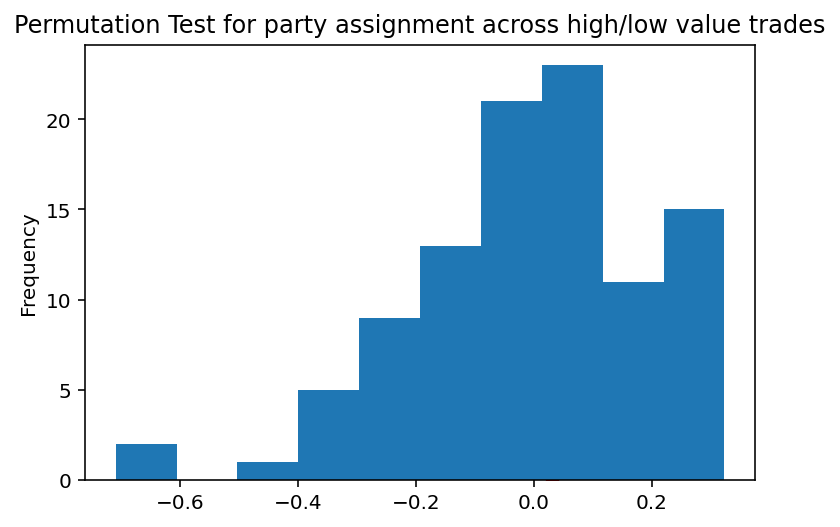

In [474]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for party assignment across high/low value trades')
plt.scatter(obs, 0.1, c='r');

As can be seen above, our p-value is ___ This means that we reject the null hypothesis with a significance level of 0.05. Thus we do treat high-value trades with the same parity as their lower-valued counterparts. Ultimately this is not the only set of subgroups we could have examined, but it is the one that we felt was the most relevant to our analysis.